---
# Query
---

## Part 0:
    - Import needed libraries 
    - Read and prepare data for work

---

In [9]:
import pandas as pd #data handling
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.corpus import stopwords
import string
from nltk.probability import FreqDist
import numpy as np
import glob

from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt # plotting

nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import Word2Vec
import re  #  preprocessing
from time import time  # time operations
from collections import defaultdict  # word frequency
from sklearn.decomposition import PCA #dimension reduction

#import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", 
                    datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trinidadbosch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# List all pickle files in the directory
file_list = glob.glob('data/*.pkl')  

# Read all pickle files and store in a list
dataframes = [pd.read_pickle(file) for file in file_list]

# Concatenate all DataFrames in the list to create a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

patentsData_2017 = pd.read_pickle("patents_ai_20230223.pkl")
patents_2017_100 = patentsData_2017.sample(n=100, random_state=42)
# Concatenate the sampled data to the previously combined DataFrame
final_combined_df = pd.concat([combined_df, patents_2017_100], ignore_index=True)

# Display the final combined DataFrame
(final_combined_df)

,publication_number,family_id,title_localized,abstract_localized,publication_date,country_code,filing_date,grant_date
0,US-9792547-B2,54142456,[{'text': 'Neural network circuit and learning...,[{'text': 'A neural network circuit includes a...,20171017,US,20150309,20171017
1,US-9741107-B2,57441857,[{'text': 'Full reference image quality assess...,[{'text': 'Embodiments generally relate to pro...,20170822,US,20150605,20170822
2,US-9552548-B1,57795176,[{'text': 'Using classified text and deep lear...,[{'text': 'Deep learning is used to identify s...,20170124,US,20160927,20170124
3,US-9666182-B2,36263105,[{'text': 'Unsupervised and active learning in...,[{'text': 'Utterance data that includes at lea...,20170530,US,20151005,20170530
4,US-9532180-B2,54870919,[{'text': 'Method of analysing data collected ...,[{'text': 'There is provided a method of analy...,20161227,US,20150618,20161227
...,...,...,...,...,...,...,...,...
1595,CN-106371599-A,57900213,[{'text': 'Method and device for high-precisio...,[{'text': '本发明公开一种深度图像中的高精度指尖定位方法及装置，能够提高定位精度。...,20170201,CN,20160908,0
1596,CN-105528516-A,55770737,"[{'text': '基于主元分析与超限学习机相结合的临床病理数据分类方法', 'langu...",[{'text': 'The present invention relates to a ...,20160427,CN,20151201,0
1597,WO-0167186-A1,11133494,[{'text': 'Method and hardware architecture fo...,[{'text': 'L&#39;invention concerne un procédé...,20010913,WO,20000309,0
1598,US-9653093-B1,58670561,[{'text': 'Generative modeling of speech using...,[{'text': 'Features are disclosed for using an...,20170516,US,20140819,20170516


In [3]:
# Extract year of patents

final_combined_df['publication_date'] = pd.to_datetime(final_combined_df['publication_date'], format='%Y%m%d', errors='coerce')

final_combined_df['year'] = final_combined_df['publication_date'].dt.year

min_year = final_combined_df['year'].min()
max_year = final_combined_df['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1979
Maximum year: 2023


In [7]:
# Drop patents from same family
final_combined_df = final_combined_df.drop_duplicates('family_id', )

In [9]:
len(final_combined_df)

1538

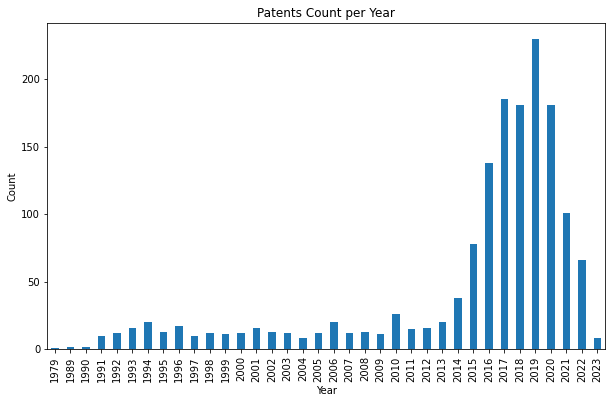

In [8]:
# plotting count of patents per year
counts_per_year = final_combined_df['year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
counts_per_year.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Patents Count per Year')
plt.show()

In [10]:
def extract_text(titles):
    try:
        for title in titles:
            if title['language']=='en':
                return title['text']
    except:
        return float('NaN')

In [11]:
#Get english text from title and abstract
final_combined_df['title'] = final_combined_df.title_localized.apply(extract_text).copy()
final_combined_df['abstract'] = final_combined_df.abstract_localized.apply(extract_text).copy()
final_combined_df.drop(['title_localized', 'abstract_localized'], axis = 1, inplace = True)

<ipython-input-11-9d032df1fe50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['title'] = final_combined_df.title_localized.apply(extract_text).copy()
<ipython-input-11-9d032df1fe50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['abstract'] = final_combined_df.abstract_localized.apply(extract_text).copy()
<ipython-input-11-9d032df1fe50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

---
## Part 1: 
### Word Frequency Statistics: Google Patents Data
    In this section I'll do a general descriptive analysis of my dataset of AI Google Patents. This description will give more insights about the words and check wheteher I need to include other terms to the original query.
    
    *11/11/23*
    Today I'm re-doing all this work but using a sample of 100 from each of the 16 tables in Google Cloud that I extracted in "patent_query.ipynb"

In [12]:
stop_words = set(stopwords.words('english'))
stop_words.add("None")

def preprocessing(text):
    if isinstance(text, str) and text.lower() != "none":
        words = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
        filtered_words = [word for word in words if word not in stop_words and not any(char.isdigit() for char in word) and word not in string.punctuation]  # Remove stopwords, numbers, and punctuation
        return filtered_words
    return [] 

In [13]:
final_combined_df['title'] = final_combined_df['title'].apply(preprocessing)
final_combined_df['abstract'] = final_combined_df['abstract'].apply(preprocessing)

<ipython-input-13-a7cb5e215e92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['title'] = final_combined_df['title'].apply(preprocessing)
<ipython-input-13-a7cb5e215e92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['abstract'] = final_combined_df['abstract'].apply(preprocessing)


In [14]:
from collections import Counter

title_words = [word for words in final_combined_df['title'] for word in words]
abstract_words = [word for words in final_combined_df['abstract'] for word in words]

title_word_freq = Counter(title_words)
abstract_word_freq = Counter(abstract_words)

In [11]:
#title_word_freq

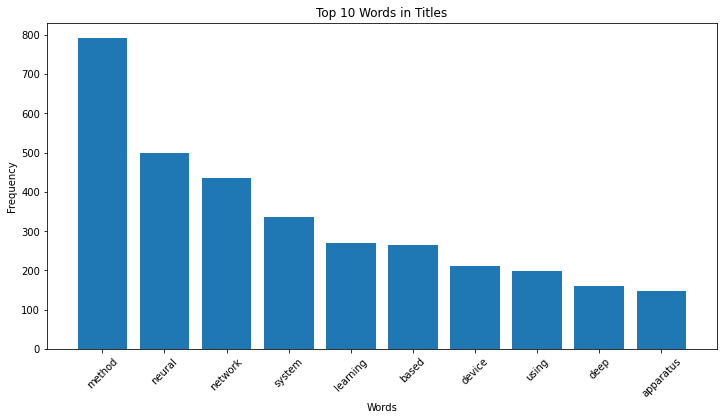

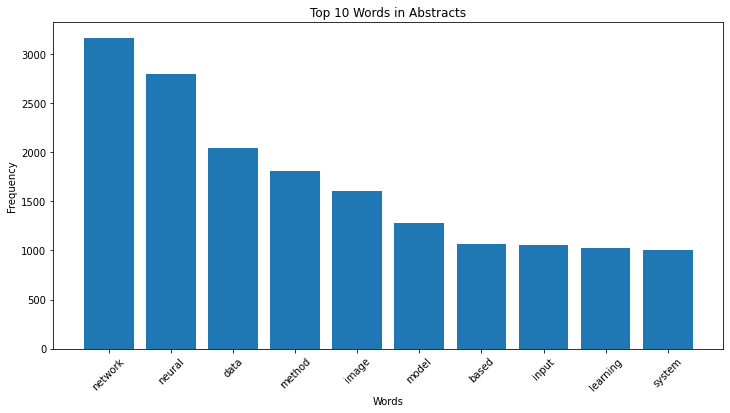

In [17]:
# Plot the most common words in titles
title_common_words = title_word_freq.most_common(10)
title_word, title_count = zip(*title_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(title_word, title_count)
plt.title("Top 10 Words in Titles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.savefig("top-10-words-titles.png")
plt.show()


# title_less_common_words = title_word_freq.most_common()[:-11:-1]
# title_less_word, title_less_count = zip(*title_less_common_words)

# plt.figure(figsize=(12, 6)) 
# plt.bar(title_less_word, title_less_count)
# plt.title("Bottom 10 Words in Titles")
# plt.xlabel("Words")
# plt.ylabel("Frequency")
# plt.xticks(rotation=45)
# plt.show()

# Plot the most common words in abstracts
abstract_common_words = abstract_word_freq.most_common(10)
abstract_word, abstract_count = zip(*abstract_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(abstract_word, abstract_count)
plt.title("Top 10 Words in Abstracts")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.savefig("top-10-words-abstract.png")
plt.show()


# # Plot the most common words in abstracts
# abstract_less_common_words = abstract_word_freq.most_common()[:-11:-1]
# abstract_less_word, abstract_less_count = zip(*abstract_less_common_words)

# plt.figure(figsize=(12, 6)) 
# plt.bar(abstract_less_word, abstract_less_count)
# plt.title("Bottom 10 Words in Abstracts")
# plt.xlabel("Words")
# plt.ylabel("Frequency")
# plt.xticks(rotation=45)
# plt.show()

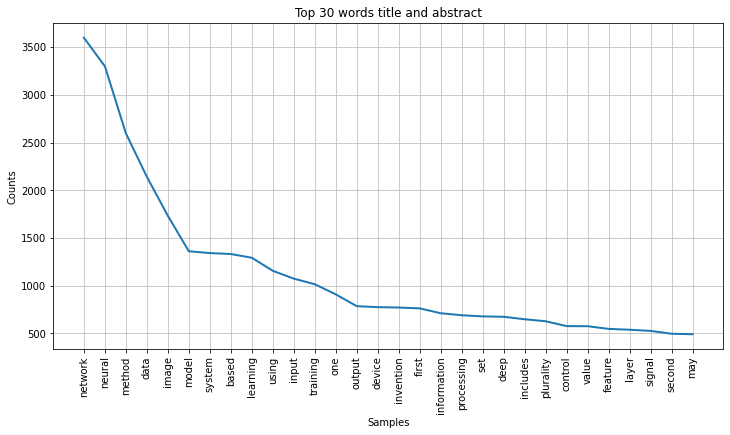

<Figure size 432x288 with 0 Axes>

In [26]:
from nltk.probability import FreqDist
# Combine title and abstract tokens into one list
all_tokens = title_words + abstract_words

# Create a frequency distribution of words
freq_dist = FreqDist(all_tokens)

plt.figure(figsize=(12, 6))
plt.title('Top 30 words title and abstract')
# Plot the word frequency distribution

freq_dist.plot(30, cumulative=False) #displaying 30 words
plt.tight_layout()
plt.savefig('top-30-words-total.png')  # Save the figure as 'word_freq_distribution.png'

plt.show()

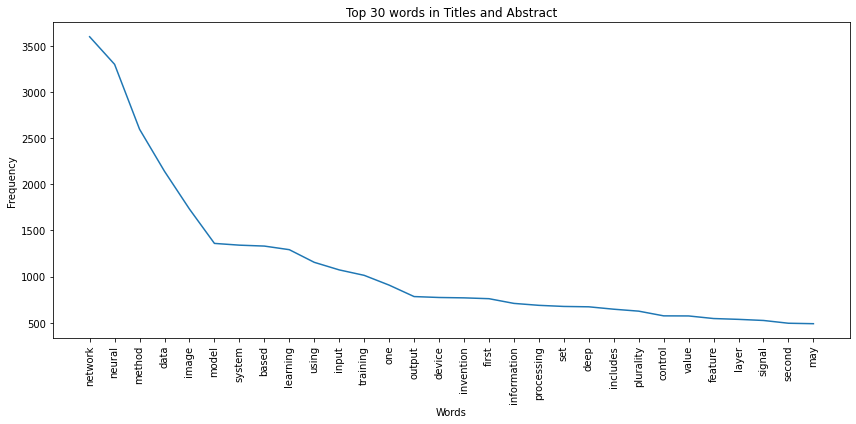

In [30]:
word_counts = freq_dist.most_common(30)  # getting 30 most common words
words, counts = zip(*word_counts)

plt.figure(figsize=(12, 6))
plt.plot(words, counts)  # Line plot with markers
plt.title('Top 30 words in Titles and Abstract')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('top-30-titles-abstract.png')  # Save the figure after displaying it
plt.show()

In [29]:
# access the frequency counts and the most common words:
common_words = freq_dist.most_common(10)
print(common_words)
print(len(all_tokens))

[('network', 3599), ('neural', 3300), ('method', 2597), ('data', 2141), ('image', 1732), ('model', 1360), ('system', 1341), ('based', 1331), ('learning', 1292), ('using', 1155)]
140282


In [32]:
from collections import defaultdict

# Combine title and abstract word frequencies
combined_word_freq = defaultdict(Counter)
for year, title_words, abstract_words in zip(final_combined_df['year'], final_combined_df['title'], final_combined_df['abstract']):
    combined_word_freq[year] += Counter(title_words)
    combined_word_freq[year] += Counter(abstract_words)

# Convert the combined_word_freq defaultdict to a regular dictionary for easier processing
combined_word_freq = dict(combined_word_freq)

# Get the range of years
min_year = final_combined_df['year'].min()
max_year = final_combined_df['year'].max()

# Initialize a dictionary to store frequencies per year
freq_per_year = {year: combined_word_freq.get(year, Counter()) for year in range(min_year, max_year + 1)}

In [33]:
# Get the top 20 common words
common_words = freq_dist.most_common(20)  # Adjust as needed
extended_years_range = range(1979, 2024)

# Create a dictionary to store frequency data for top 20 words over the years
top_words_freq_per_year = {word: [freq_per_year.get(year, Counter()).get(word, 0) for year in extended_years_range] for word, _ in common_words}

# Create a DataFrame to store the count of top 20 words per year
df = pd.DataFrame({'Year': extended_years_range})
for word, freq_list in top_words_freq_per_year.items():
    df[word] = freq_list

# Display the table
#(df)


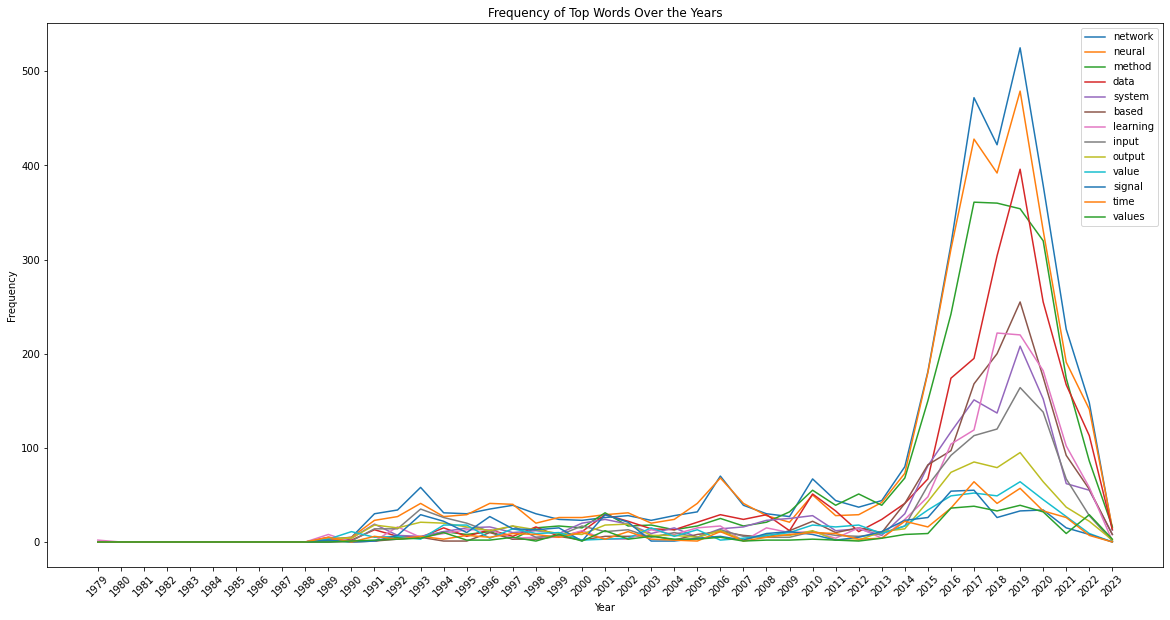

In [36]:
# Combine title and abstract tokens into one list
all_tokens = [word for year in freq_per_year.values() for word in year]

# Create a frequency distribution of words
freq_dist = Counter(all_tokens)

# Get the top 10 common words
common_words = freq_dist.most_common(15)  # Adjust as needed

words_to_exclude = ['using', 'used']

# Remove 'using' and 'used' from the common words list
common_words = [word for word in common_words if word[0] not in words_to_exclude]

# Create a dictionary to store frequency data for top 10 words over the years
top_words_freq_per_year = {word: [freq_per_year.get(year, Counter()).get(word, 0) for year in range(min_year, max_year + 1)] for word, _ in common_words}

# Sort legend labels by total frequency across the years
sorted_legend_labels = [word for word, _ in sorted(top_words_freq_per_year.items(), key=lambda x: sum(x[1]), reverse=True)]

# Plotting the frequencies of top words over the years with sorted legend labels
plt.figure(figsize=(20, 10))

for word in sorted_legend_labels:
    freq_list = top_words_freq_per_year[word]
    plt.plot(extended_years_range, freq_list, label=word)

plt.legend()
plt.xticks(extended_years_range, rotation=45)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Top Words Over the Years')
plt.savefig("top-15-words-over-years.png")
plt.show()

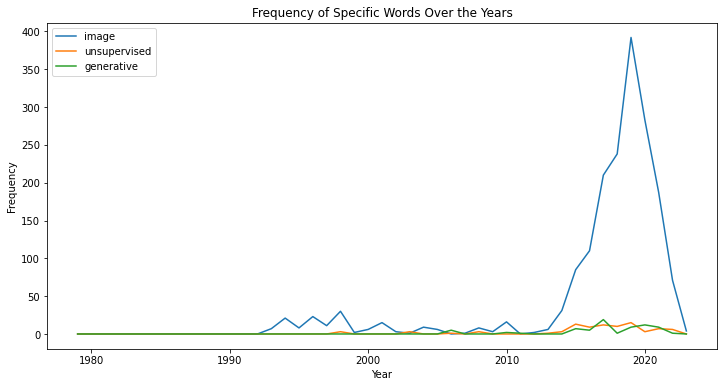

In [30]:
## inspecting some specific terms over the years
specific_words = ['image', 'unsupervised', 'generative']  # Add more words as needed

# Create a dictionary to store frequency data for specific words over the years
specific_words_freq_per_year = {word: [freq_per_year.get(year, Counter()).get(word, 0) for year in range(min_year, max_year + 1)] for word in specific_words}

# Plotting the frequencies of specific words over the years
plt.figure(figsize=(12, 6))

for word, freq_list in specific_words_freq_per_year.items():
    plt.plot(extended_years_range, freq_list, label=word)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Specific Words Over the Years')
plt.show()

#### Check for outliers

In [18]:
# Get word frequencies as an array
word_frequencies = np.array(list(freq_dist.values()))

# Calculate summary statistics
mean_frequency = np.mean(word_frequencies)
std_deviation = np.std(word_frequencies)

# Define a threshold for identifying outliers (e.g., words more than 2 standard deviations away)
outlier_threshold = mean_frequency + 2 * std_deviation

# Identify words that are outliers
outliers = {word: freq for word, freq in freq_dist.items() if freq > outlier_threshold}

# Create a DataFrame for the outliers
outliers_df = pd.DataFrame(list(outliers.items()), columns=['Word', 'Frequency'])

# Find the word with the maximum frequency among outliers
max_freq_word = outliers_df.loc[outliers_df['Frequency'].idxmax()]

# Find the word with the minimum frequency among outliers
min_freq_word = outliers_df.loc[outliers_df['Frequency'].idxmin()]

# Display the DataFrame and the words with max and min frequencies
print(outliers_df)
print("Word with Maximum Frequency:", max_freq_word)
print("Word with Minimum Frequency:", min_freq_word)

             Word  Frequency
0           three         18
1      containing         15
2       disclosed         28
3             may         29
4           known         16
..            ...        ...
561       samples         14
562       aspects         14
563            bp         13
564   established         14
565  establishing         13

[566 rows x 2 columns]
Word with Maximum Frequency: Word         learning
Frequency          35
Name: 11, dtype: object
Word with Minimum Frequency: Word         manner
Frequency        13
Name: 5, dtype: object


---
---
### Analyzing the first decade of data
    After doing a fine grained analysis I realized that only 4 rows of data is my first decade, which translate to very small frequency of words in that period. So I decided to go ahead and only use data from 1990 onwards

In [17]:
# Display unique years in the dataset
unique_years = final_combined_df['publication_date'].dt.year.unique()
unique_years = sorted(unique_years)
print(unique_years)

[1979, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [24]:
# Filter the data for the first decade (1979 to 1990)
first_decade_data = final_combined_df[(final_combined_df['year'] >= 1979) & (final_combined_df['year'] <= 1990)]
count_per_year = first_decade_data['publication_date'].dt.year.value_counts().sort_index()
print(count_per_year)

publication_date
1979    1
1989    2
1990    2
Name: count, dtype: int64


In [22]:
# Filter the dataset for the specified years
selected_years_data = final_combined_df[final_combined_df['publication_date'].dt.year.isin([1979, 1989, 1990])]

In [23]:
# Sort the dataset by 'publication_date' in ascending order
sorted_data = final_combined_df.sort_values(by='publication_date', ascending=True)

# Display the sorted dataset
sorted_data.head(20)

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,year,title,abstract
248,US-4176473-A,25314255,1979-12-04,US,19771118,19791204,1979,"[book, removable, three, dimensional, figurines]","[multi-page, book, containing, removable, thre..."
917,JP-H01204171-A,12282658,1989-08-16,JP,19880209,0,1989,"[dynamic, neural, network, learning, mechanism]","[purpose, realize, learning, method, performs,..."
250,GB-8915483-D0,22824891,1989-08-23,GB,19890706,19890823,1989,"[continuous-time, optical, neural, network, pr...",[]
1125,JP-H02271464-A,14101436,1990-11-06,JP,19890413,0,1990,"[neural, network, simulator]","[purpose, realize, neural, network, simulator,..."
225,JP-H02304493-A,14882265,1990-12-18,JP,19890519,0,1990,"[voice, synthesizer, system]","[purpose, synthesize, smooth, intoned, voice, ..."
1529,US-5004309-A,26927048,1991-04-02,US,19890613,19910402,1991,"[neural, processor, holographic, optical, path...","[optical, apparatus, simulating, highly, inter..."
776,JP-H03111899-A,17202173,1991-05-13,JP,19890926,0,1991,"[voice, lock, device]","[purpose, reduce, deterioration, normal, opera..."
1438,US-5017375-A,27033845,1991-05-21,US,19870518,19910521,1991,"[method, prepare, neurotrophic, composition]","[present, invention, based, discovery, amyotro..."
1105,JP-H03143057-A,17638417,1991-06-18,JP,19891028,0,1991,"[voice, dial, telephone, set]","[purpose, eliminate, secular, deterioration, n..."
906,JP-H03186979-A,18193991,1991-08-14,JP,19891215,0,1991,"[posture, hand, recognition, system, using, ne...","[purpose, give, instructions, computer, humanl..."


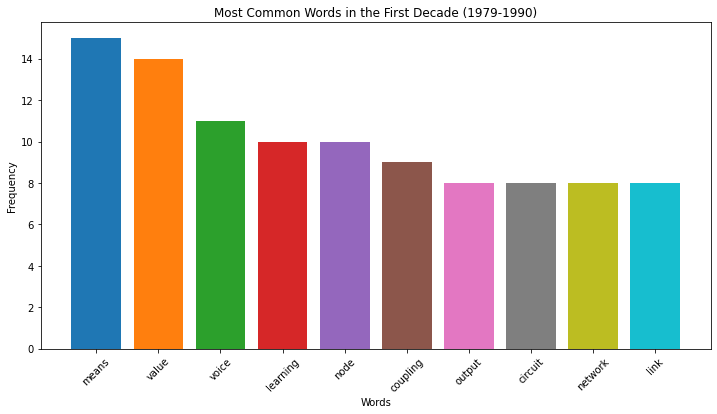

In [25]:
# Combine title and abstract tokens into one list for the first decade
all_tokens_first_decade = [word for year in first_decade_data['title'] + first_decade_data['abstract'] for word in year]

# Create a frequency distribution of words for the first decade
freq_dist_first_decade = Counter(all_tokens_first_decade)

# Get the most common words for the first decade
most_common_words_first_decade = freq_dist_first_decade.most_common(10)  

# Plotting the frequencies of most common words in the first decade
plt.figure(figsize=(12, 6))

for word, freq in most_common_words_first_decade:
    plt.bar(word, freq)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in the First Decade (1979-1990)')
plt.xticks(rotation=45)
plt.show()


---
## Part 2:
### word2vec 

    The idea here is to replicate Balsamo et.al vocabulary expansion chapter to find more insights for my final query
    Following this tutorial https://www.analyticsvidhya.com/blog/2023/07/step-by-step-guide-to-word2vec-with-gensim/
---

In [39]:
# merging title and abstract into a single column to get all the text
#patentsData['allText'] = patentsData['title'] + ' ' + patentsData['abstract']
# Fill missing or empty values with an empty string
# final_combined_df['title'] = final_combined_df['title'].fillna('').astype(str)
# final_combined_df['abstract'] = final_combined_df['abstract'].fillna('').astype(str)
# final_combined_df['allText'] = final_combined_df['title'].str.cat(final_combined_df['abstract'], sep=' ')

final_combined_df['title'] = final_combined_df['title'].fillna('')
final_combined_df['abstract'] = final_combined_df['abstract'].fillna('')
final_combined_df['allText'] = final_combined_df['title'].str.cat(final_combined_df['abstract'], sep=' ')

<ipython-input-39-fcf9ba236b60>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['title'] = final_combined_df['title'].fillna('')
<ipython-input-39-fcf9ba236b60>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_combined_df['abstract'] = final_combined_df['abstract'].fillna('')


TypeError: Cannot use .str.cat with values of inferred dtype 'mixed'.

In [60]:
# Define a function to preprocess and tokenize text
def preprocess_and_tokenize_text(text):
    if isinstance(text, str) and text.lower() != "none":
        # words = text.split()  # Split the text into words
        # filtered_words = [word.lower() for word in words if word.lower() not in stop_words]  # Remove stopwords
        # return word_tokenize(' '.join(filtered_words))  # Tokenize and join the remaining words
        words = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
        filtered_words = [word for word in words if word not in stop_words and not any(char.isdigit() for char in word) and word not in string.punctuation]  # Remove stopwords, numbers, and punctuation
        return filtered_words
    return []  # Return an empty list for "None" or None

In [61]:
final_combined_df['allText'] = final_combined_df['allText'].apply(preprocess_and_tokenize_text)

In [62]:
#sentences
final_combined_df

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,year,title,abstract,allText
0,US-9792547-B2,54142456,2017-10-17,US,20150309,20171017,2017,Neural network circuit and learning method for...,A neural network circuit includes an error cal...,"[neural, network, circuit, learning, method, n..."
1,US-9741107-B2,57441857,2017-08-22,US,20150605,20170822,2017,Full reference image quality assessment based ...,Embodiments generally relate to providing syst...,"[full, reference, image, quality, assessment, ..."
2,US-9552548-B1,57795176,2017-01-24,US,20160927,20170124,2017,Using classified text and deep learning algori...,"Deep learning is used to identify specific, po...","[using, classified, text, deep, learning, algo..."
3,US-9666182-B2,36263105,2017-05-30,US,20151005,20170530,2017,Unsupervised and active learning in automatic ...,Utterance data that includes at least a small ...,"[unsupervised, active, learning, automatic, sp..."
4,US-9532180-B2,54870919,2016-12-27,US,20150618,20161227,2016,Method of analysing data collected in a cellul...,There is provided a method of analyzing data c...,"[method, analysing, data, collected, cellular,..."
...,...,...,...,...,...,...,...,...,...,...
1595,CN-106371599-A,57900213,2017-02-01,CN,20160908,0,2017,Method and device for high-precision fingertip...,The invention discloses a method and a device ...,"[method, device, high-precision, fingertip, po..."
1596,CN-105528516-A,55770737,2016-04-27,CN,20151201,0,2016,Clinic pathology data classification method ba...,The present invention relates to a clinic path...,"[clinic, pathology, data, classification, meth..."
1597,WO-0167186-A1,11133494,2001-09-13,WO,20000309,0,2001,Method and hardware architecture for controlli...,A method of controlling a process (Plant) driv...,"[method, hardware, architecture, controlling, ..."
1598,US-9653093-B1,58670561,2017-05-16,US,20140819,20170516,2017,Generative modeling of speech using neural net...,Features are disclosed for using an artificial...,"[generative, modeling, speech, using, neural, ..."


In [63]:
from gensim.models import Word2Vec

# # preparing input
# sentences = final_combined_df['allText'].tolist()

# # Train Word2Vec model
# model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0, hs=0, negative=5, workers=4, epochs=10)

# # Save the model for later use
# model.save("word2vec_modelPatents_12nov.model")

INFO - 18:18:47: collecting all words and their counts
INFO - 18:18:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 18:18:47: collected 9753 word types from a corpus of 145283 raw words and 1600 sentences
INFO - 18:18:47: Creating a fresh vocabulary
INFO - 18:18:47: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 9753 unique words (100.00% of original 9753, drops 0)', 'datetime': '2023-11-12T18:18:47.230842', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 18:18:47: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 145283 word corpus (100.00% of original 145283, drops 0)', 'datetime': '2023-11-12T18:18:47.231940', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 18:18:47: deleting the raw counts 

In [40]:
model_old = Word2Vec.load("word2vec_model2.model")
model_all = Word2Vec.load("word2vec_modelPatents_12nov.model")

INFO - 13:20:36: loading Word2Vec object from word2vec_model2.model
INFO - 13:20:36: loading wv recursively from word2vec_model2.model.wv.* with mmap=None
INFO - 13:20:36: setting ignored attribute cum_table to None
INFO - 13:20:37: Word2Vec lifecycle event {'fname': 'word2vec_model2.model', 'datetime': '2023-11-13T13:20:37.003630', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}
INFO - 13:20:37: loading Word2Vec object from word2vec_modelPatents_12nov.model
INFO - 13:20:37: loading wv recursively from word2vec_modelPatents_12nov.model.wv.* with mmap=None
INFO - 13:20:37: setting ignored attribute cum_table to None
INFO - 13:20:37: Word2Vec lifecycle event {'fname': 'word2vec_modelPatents_12nov.model', 'datetime': '2023-11-13T13:20:37.261752', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event'

In [174]:
## trying others
image_nn = model_all.wv.most_similar("convolutional-neural-network-based", topn=25)

# # Create a Pandas DataFrame for the nearest neighbors
# df_image_nn = pd.DataFrame(image_nn, columns=['Word', 'Cosine Similarity'])

# # Save the output to a text file
# df_image_nn.to_csv('ai_nearest_neighbors.txt', index=False, sep='\t')
image_nn

[('adversarial', 0.9133799076080322),
 ('localizing', 0.9032760262489319),
 ('machine-learning', 0.8904141187667847),
 ('training', 0.890204668045044),
 ('sufficiency', 0.886759877204895),
 ('classifier', 0.8837308883666992),
 ('convolutional', 0.8837093114852905),
 ('forwardly', 0.880824863910675),
 ('bayesian', 0.880498468875885),
 ('using', 0.8779224157333374),
 ('dermal', 0.8740701079368591),
 ('structure', 0.870398998260498),
 ('-based', 0.8645802736282349),
 ('generative', 0.8645401000976562),
 ('wellbores', 0.8643854856491089),
 ('multi-wave', 0.8621413707733154),
 ('shown', 0.8589292764663696),
 ('seed', 0.8575389385223389),
 ('cnn', 0.8566064238548279),
 ('classification', 0.853942334651947),
 ('contention', 0.8534692525863647),
 ('nodule', 0.8534533381462097),
 ('prosthesis', 0.8533042073249817),
 ('model', 0.8531742095947266),
 ('synchrony', 0.8520699143409729)]

In [157]:

supervised_nn = model_all.wv.most_similar("supervised", topn=25)
unsupervised_nn = model_all.wv.most_similar("unsupervised", topn=25)

# Create dictionaries of nearest neighbors for decoder and encoder
supervised_dict = dict(supervised_nn)
unsupervised_dict = dict(unsupervised_nn)

# Find the common nearest neighbors and their cosine similarity
shared_nn = set(supervised_dict).intersection(unsupervised_dict)
shared_with_similarity = {word: (supervised_dict[word], unsupervised_dict[word]) for word in shared_nn}

# Create a Pandas DataFrame for table representation
table_data_sup_unsup = {'Nearest Neighbor': list(shared_with_similarity.keys()),
              'Cosine Similarity (Supervised)': [similarity[0] for similarity in shared_with_similarity.values()],
              'Cosine Similarity (Unsupervised)': [similarity[1] for similarity in shared_with_similarity.values()]}

df_sup_unsup = pd.DataFrame(table_data_sup_unsup)

# Print the table
(df_sup_unsup)


,Nearest Neighbor,Cosine Similarity (Supervised),Cosine Similarity (Unsupervised)
0,train,0.914351,0.916567
1,semi-supervised,0.955281,0.961881
2,reinforcement,0.885306,0.892982
3,algorithm,0.886781,0.902260
4,bayesian,0.881107,0.894687
5,support,0.925301,0.939319
6,generative,0.880172,0.895920
7,models,0.927909,0.934222
8,forests,0.883461,0.891041
9,algorithms,0.915786,0.931194


In [42]:
# Access the Word2Vec model's vocabulary
vocabulary = model_all.wv.key_to_index

# Check the vocabulary
print(list(vocabulary.keys()))

['network', 'neural', 'method', 'data', 'image', 'system', 'model', 'based', 'learning', 'using', 'input', 'training', 'one', 'output', 'first', 'device', 'invention', 'information', 'processing', 'set', 'deep', 'includes', 'plurality', 'signal', 'value', 'control', 'feature', 'layer', 'may', 'second', 'images', 'according', 'detection', 'time', 'target', 'least', 'apparatus', 'comprises', 'trained', 'user', 'prediction', 'unit', 'methods', 'recognition', 'present', 'used', 'convolutional', 'object', 'corresponding', 'process', 'artificial', 'parameters', 'values', 'networks', 'parameter', 'provided', 'function', 'vector', 'state', 'systems', 'including', 'computer', 'module', 'classification', 'result', 'obtain', 'features', 'video', 'sequence', 'analysis', 'algorithm', 'machine', 'generating', 'vehicle', 'determining', 'obtained', 'current', 'steps', 'operation', 'wherein', 'point', 'memory', 'generate', 'configured', 'generated', 'sample', 'discloses', 'speech', 'also', 'step', 'wei

In [175]:
## model all
queries = [
    "neural-network",
    "deep-learning",
    "reinforcement-learning",
    "supervised-learning",
    "unsupervised-learning",
    "generative"
]

# # Find nearest neighbors for each query
# for query in queries:
#     similar_words = model_all.wv.most_similar(query, topn=5)
#     print(f"Nearest neighbors for '{query}':")
#     for word, similarity in similar_words:
#         print(f"{word}: {similarity:.4f}")
#     print()
    
# Open a text file in write mode
with open('nearest_neighbors_model_old.txt', 'w') as file:
    for query in queries:
        similar_words = model_old.wv.most_similar(query, topn=20)
        file.write(f"Model allNearest neighbors for '{query}':\n")
        for word, similarity in similar_words:
            file.write(f"{word}: {similarity:.4f}\n")
        file.write('\n')


In [48]:
## first model
queries = [
    "neural-network",
    "deep-learning",
    "reinforcement-learning",
    "supervised",
    "unsupervised",
    "generative"
]

# Find nearest neighbors for each query
for query in queries:
    similar_words = model_old.wv.most_similar(query, topn=20)
    print(f"Nearest neighbors for '{query}':")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
    print()
    
# # Open a text file in write mode
# with open('nearest_neighbors_model_all.txt', 'w') as file:
#     for query in queries:
#         similar_words = model_all.wv.most_similar(query, topn=20)
#         file.write(f"Model allNearest neighbors for '{query}':\n")
#         for word, similarity in similar_words:
#             file.write(f"{word}: {similarity:.4f}\n")
#         file.write('\n')

Nearest neighbors for 'neural-network':
neuro-fuzzy: 0.6017
self-adapting: 0.5690
hammerstein: 0.5627
leanring: 0.5415
multi-output: 0.5257
inner-loop: 0.5223
multi-model: 0.5165
one-order: 0.5149
levenberg-marquardt: 0.5078
multi-input/output: 0.5035
traceless: 0.5015
multi-variable: 0.4998
fuzzy-neural: 0.4957
petri: 0.4944
soft-sensing: 0.4916
adaline: 0.4908
double-layer: 0.4897
evolutionary: 0.4868
surrogate: 0.4863
stochastic: 0.4861

Nearest neighbors for 'deep-learning':
objectnets: 0.6461
entities: 0.6445
ising: 0.6222
cox: 0.6047
diploid: 0.6032
part-based: 0.6031
parser: 0.5867
depth-dependent: 0.5829
mnemonic: 0.5751
coefficiency: 0.5742
steering-model: 0.5719
log-linear: 0.5691
coercion: 0.5669
voice-dialing: 0.5655
object-oriented: 0.5637
machine-learning: 0.5578
pca-nn: 0.5531
phrases: 0.5520
econometric: 0.5502
aft: 0.5479

Nearest neighbors for 'reinforcement-learning':
action-selection: 0.8658
deep-credibility: 0.6549
network-cloud: 0.6503
relm: 0.6470
avid: 0.6448
up

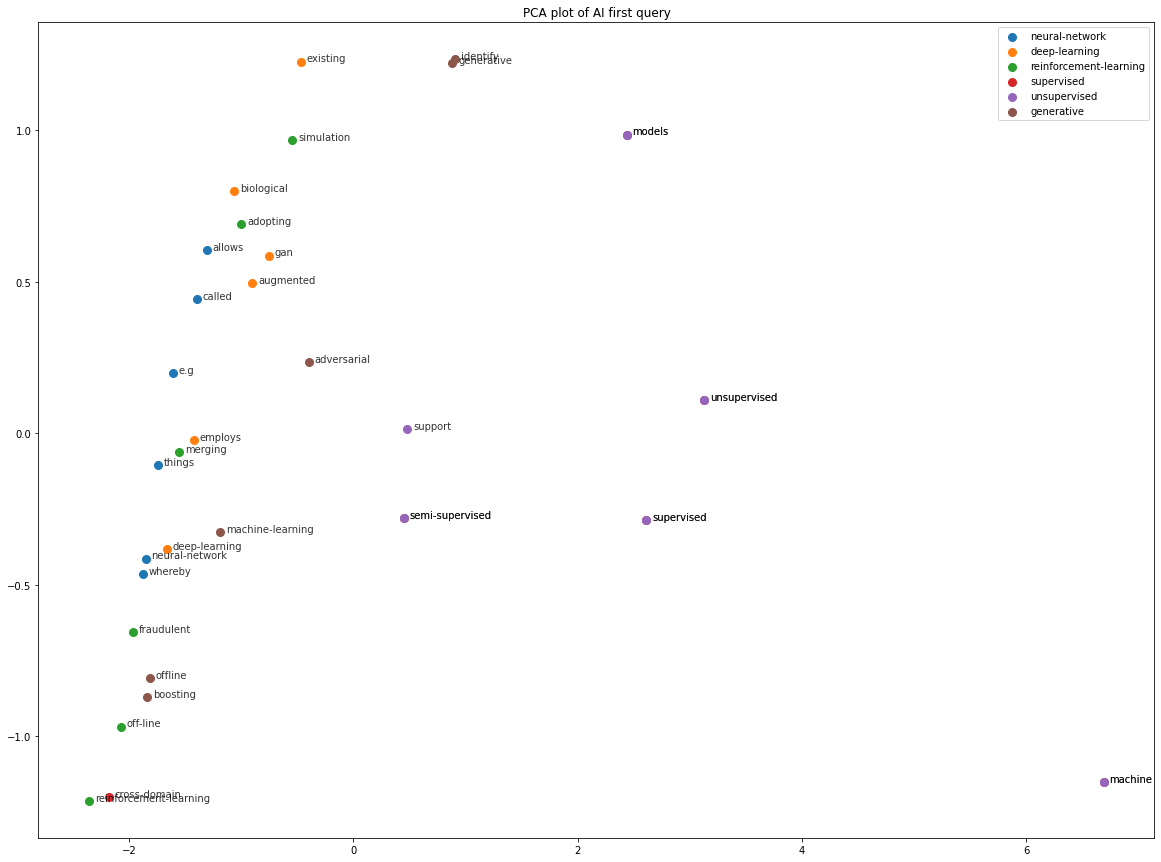

In [123]:
#listing the query
words_to_visualize = [
    "neural-network",
    "deep-learning",
    "reinforcement-learning",
    "supervised",
    "unsupervised",
    "generative"
]

# dictionary to store most similar words for each word
most_similar_words = {word: model_all.wv.most_similar(word, topn=5) for word in words_to_visualize}

# lst that includes the words and their most similar words
data_points = []

for word in words_to_visualize:
    data_points.append((word, word, 0.0, True))  # Add the central word with True for highlighting
    for similar_word, similarity in most_similar_words[word]:
        data_points.append((similar_word, word, similarity, False))  # Add the similar words with False

# Convert the data to a DataFrame
data = pd.DataFrame(data_points, columns=['Word', 'Central_Word', 'Similarity', 'Highlight'])

# PCA for dimension reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data['Word'].apply(lambda x: model_all.wv[x]).values.tolist())

# plotting
plt.rcParams["figure.figsize"] = (20, 15)

for central_word in words_to_visualize:
    central_word_data = data[data['Central_Word'] == central_word]
    scatter = plt.scatter(x=pca_result[central_word_data.index, 0], y=pca_result[central_word_data.index, 1], s=64, label=central_word, marker='o')

for i, row in data.iterrows():
    if row['Highlight']:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8)
    else:
        plt.annotate(row['Word'], (pca_result[i, 0], pca_result[i, 1]), xytext=(pca_result[i, 0] + 0.05, pca_result[i, 1]), fontsize=10, alpha=0.8, color='black')

plt.title(f"PCA plot of AI first query")
plt.legend()
#plt.savefig("word2vec_query_patents-12nov.png")
plt.show()

---
##  TF-IDF
       Here I'm applying Nearest Neighbor this Google Patents dataset I have in order to expand my final query.
---

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
title_tfidf_matrix = tfidf_vectorizer.fit_transform(final_combined_df['title'].apply(lambda x: ' '.join(x)))
abstract_tfidf_matrix = tfidf_vectorizer.fit_transform(final_combined_df['abstract'].apply(lambda x: ' '.join(x)))

In [159]:
from scipy.sparse import hstack

# Combine the TF-IDF matrices
combined_features = hstack([title_tfidf_matrix, abstract_tfidf_matrix]).tocsr()

In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Create a single TF-IDF vectorizer and fit it on the text data
tfidf_vectorizer = TfidfVectorizer()
all_text = final_combined_df['title'].apply(lambda x: ' '.join(x)) + ' ' + final_combined_df['abstract'].apply(lambda x: ' '.join(x))
tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

# Create a nearest neighbors model using the combined TF-IDF matrix
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(tfidf_matrix)

# Define a function to find similar documents for a query
def find_similar_documents(query, n_neighbors=20):
    query_tfidf = tfidf_vectorizer.transform([query])
    distances, indices = nn_model.kneighbors(query_tfidf, n_neighbors=n_neighbors)
    
    # Filter out documents with empty abstracts
    similar_patents = final_combined_df.iloc[indices[0]]
    similar_patents = similar_patents[similar_patents['abstract'].apply(lambda x: len(x) > 0)] ##filtering empty abstracts
    
    return distances, similar_patents

In [163]:
import io
import sys

In [166]:
#%%capture captured_output

# Create an StringIO object to capture the printed output
captured_output = io.StringIO()
sys.stdout = captured_output
    
# AI queries
queries = [
    "neural network",
    "deep learning",
    "reinforcement learning",
    "supervised learning",
    "unsupervised learning",
    "generative model"
]

similar_documents = []

for query in queries:
    similar_documents.append(find_similar_documents(query))

# Iterate through similar documents for each query
for i, query in enumerate(queries):
    distances, similar_docs = similar_documents[i]  # Retrieve the similar documents for the current query
    
    for j, (index, row) in enumerate(similar_docs.iterrows(), start=1):
        title_words = row['title']
        abstract_words = row['abstract']

        print(f"Query: {query}")
        print(f"Document {j} at index {index}")
        print(f"Title Words: {title_words}")
        print(f"Abstract Words: {abstract_words}")
        print(f"Cosine Distance: {distances[0][j-1]}")

# Reset sys.stdout to its original value
sys.stdout = sys.__stdout__

# Save the captured output to a text file
with open('nn-tfidf-1600-patents.txt', 'w') as file:
    file.write(captured_output.getvalue())

In [171]:
distances, similar_patents = find_similar_documents("image", n_neighbors=10)
similar_patents
#distances

,publication_number,family_id,publication_date,country_code,filing_date,grant_date,year,title,abstract
1159,CN-107562805-B,60975174,2020-04-03,CN,20170808,20200403,2020,"[method, device, searching, picture, picture]","[present, application, relates, field, image, ..."
1022,JP-2018156640-A,63522380,2018-10-04,JP,20180209,0,2018,[],"[problem, solved, provide, learning, method, c..."
1225,US-2019362200-A1,68614663,2019-11-28,US,20190520,0,2019,"[image, processing, method, apparatus, neural,...","[method, apparatus, adjusting, neural, network..."
1307,US-9760807-B2,59275935,2017-09-12,US,20161216,20170912,2017,"[deep, image-to-image, network, learning, medi...","[method, apparatus, automatically, performing,..."
1,US-9741107-B2,57441857,2017-08-22,US,20150605,20170822,2017,"[full, reference, image, quality, assessment, ...","[embodiments, generally, relate, providing, sy..."
977,WO-2019043525-A1,65525059,2019-03-07,WO,20180823,0,2019,"[image, processing, method, semiconductor, dev...","[abstract, provided, semiconductor, device, pe..."
291,US-2017230675-A1,57851362,2017-08-10,US,20161230,0,2017,"[compressing, images, using, neural, networks]","[methods, systems, apparatus, including, compu..."
1237,US-2019034714-A1,55361341,2019-01-31,US,20170131,0,2019,"[system, method, detecting, hand, gestures, sp...","[system, detecting, hand, gestures, space, com..."
989,JP-2019061642-A,62628831,2019-04-18,JP,20180125,0,2019,"[video, processing, device, method, thereof]","[present, invention, provides, image, processi..."


---
---
    End of script

In [66]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [72]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased' ## check other BERT versionss!!
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Prepare sentences from the DataFrame
sentences = final_combined_df['allText'].tolist()
sample_sentences = final_combined_df['allText'].head(10).tolist()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [70]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [73]:
# Create a list to store the BERT sentence embeddings
bert_embeddings = []

# Iterate through each sentence and get BERT embeddings
for sentence in sample_sentences:
    # Tokenize the sentence and get IDs
    tokens = tokenizer.encode(sentence, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])

    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(tokens_tensor)

    # Extract the embeddings of the entire sentence (CLS token)
    sentence_embedding = np.mean(outputs.last_hidden_state[0].numpy(), axis=0)  # Average of token embeddings
    bert_embeddings.append(sentence_embedding)

In [75]:
#bert_embeddings

In [76]:
# list of queries
queries = [
    "neural network",
    "deep learning",
    "reinforcement learning",
    "supervised learning",
    "unsupervised learning",
    "'generative model"
]

# Create a list to store the BERT embeddings for queries
query_embeddings = []

# Iterate through each query and get BERT embeddings
for query in queries:
    # Tokenize the query and get its BERT embedding
    query_tokens = tokenizer.encode(query, add_special_tokens=True)
    query_tokens_tensor = torch.tensor([query_tokens])

    # Get BERT embeddings for the query
    with torch.no_grad():
        query_outputs = model(query_tokens_tensor)
    query_embedding = np.mean(query_outputs.last_hidden_state[0].numpy(), axis=0)  # Average of token embeddings
    query_embeddings.append(query_embedding)

In [81]:
from sklearn.metrics.pairwise import cosine_similarity

# Use the precomputed BERT embeddings for sentences (bert_embeddings) and query embeddings
# bert_embeddings: embeddings for sentences in dataset
# query_embeddings: embeddings for queries

# Find nearest neighbors for each query
for query_idx, query_embedding in enumerate(query_embeddings):
    # Calculate cosine similarity between the query embedding and all sentence embeddings
    similarities = cosine_similarity([query_embedding], bert_embeddings)[0]

    # Find the indices of top N most similar sentences
    N = 5  # Number of nearest neighbors
    top_indices = similarities.argsort()[-N:][::-1]

    # Extract and print the top N similar sentences and their similarity scores with the associated query
    print(f"Nearest neighbors for query: '{queries[query_idx]}':\n")
    for idx in top_indices:
        print("Sentence: \n", sample_sentences[idx])
    print()


Nearest neighbors for query: 'neural network':

Sentence: 
 ["'generating", "'preference", "'indices", "'image", "'content", "'briefly", "'embodiments", "'methods", "'and/or", "'systems", "'generating", "'preference", "'indices", "'contiguous", "'portions", "'digital", "'images", "'disclosed", "'one", "'embodiment", "'example", "'parameters", "'neural", "'network", "'may", "'developed", "'generate", "'object", "'labels", "'digital", "'images", "'developed", "'parameters", "'may", "'transferred", "'neural", "'network", "'utilized", "'generate", "'signal", "'sample", "'value", "'levels", "'corresponding", "'preference", "'indices", "'contiguous", "'portions", "'digital", "'images"]
Sentence: 
 ["'full", "'reference", "'image", "'quality", "'assessment", "'based", "'convolutional", "'neural", "'network", "'embodiments", "'generally", "'relate", "'providing", "'systems", "'methods", "'assessing", "'image", "'quality", "'distorted", "'image", "'relative", "'reference", "'image", "'one", "'e

In [14]:
patents_total = pd.read_pickle('data/patents_all_final.pkl')

In [5]:
patents_total.head()

,publication_number,family_id,title_localized,abstract_localized,publication_date,country_code,filing_date,grant_date
0,US-2014297284-A1,47007095,[{'text': 'Using context information to facili...,[{'text': 'A virtual assistant uses context in...,20141002,US,20140612,0
1,US-11079279-B2,71400764,[{'text': 'Diagnosis method using laser induce...,[{'text': 'Disclosed herein are a diagnostic m...,20210803,US,20200430,20210803
2,US-11096602-B2,61011844,[{'text': 'Methods and systems for characteriz...,[{'text': 'Methods and systems for characteriz...,20210824,US,20170728,20210824
3,US-10853409-B2,62490131,[{'text': 'Systems and methods for image searc...,[{'text': 'The present disclosure relates to a...,20201201,US,20170629,20201201
4,US-11748569-B2,78293308,[{'text': 'System and method for query authori...,"[{'text': 'Systems, methods, and computer-read...",20230905,US,20221220,20230905


In [6]:
len(patents_total)

337166

In [15]:
# Convert 'publish_date' to datetime
patents_total['publication_date'] = pd.to_datetime(patents_total['publication_date'], format='%Y%m%d')

# Convert 'publish_date' to datetime
#patents_total['publication_date'] = pd.to_datetime(patents_total['publication_date'], errors='coerce')

# Extract year-month
patents_total['year_month'] = patents_total['publication_date'].dt.to_period('M')

# Filter for the first 5 years
first_5_years_df = patents_total[patents_total['publication_date'].dt.year <= patents_total['publication_date'].dt.year.min() + 4]

# Filter for the next 5 years
next_5_years_df = patents_total[patents_total['publication_date'].dt.year > patents_total['publication_date'].dt.year.min() + 4]


In [16]:
patents_total

,publication_number,family_id,title_localized,abstract_localized,publication_date,country_code,filing_date,grant_date,year_month
0,US-2014297284-A1,47007095,[{'text': 'Using context information to facili...,[{'text': 'A virtual assistant uses context in...,2014-10-02,US,20140612,0,2014-10
1,US-11079279-B2,71400764,[{'text': 'Diagnosis method using laser induce...,[{'text': 'Disclosed herein are a diagnostic m...,2021-08-03,US,20200430,20210803,2021-08
2,US-11096602-B2,61011844,[{'text': 'Methods and systems for characteriz...,[{'text': 'Methods and systems for characteriz...,2021-08-24,US,20170728,20210824,2021-08
3,US-10853409-B2,62490131,[{'text': 'Systems and methods for image searc...,[{'text': 'The present disclosure relates to a...,2020-12-01,US,20170629,20201201,2020-12
4,US-11748569-B2,78293308,[{'text': 'System and method for query authori...,"[{'text': 'Systems, methods, and computer-read...",2023-09-05,US,20221220,20230905,2023-09
...,...,...,...,...,...,...,...,...,...
337161,WO-0231764-A2,8170085,[{'text': 'Procede d&#39;apprentissage supervi...,[{'text': 'L&#39;invention concerne un procédé...,2002-04-18,WO,20011005,0,2002-04
337162,WO-2010146199-A3,43356814,[{'text': 'Identification et caractérisation i...,[{'text': 'L&#39;invention concerne l&#39;iden...,2011-07-14,WO,20100618,0,2011-07
337163,EP-3407265-A4,59361382,[{'text': 'Device and method for executing for...,[],2019-09-04,EP,20160401,0,2019-09
337164,EP-3788625-A4,68385458,[{'text': 'Method and apparatus for high volta...,[],2022-04-20,EP,20190408,0,2022-04


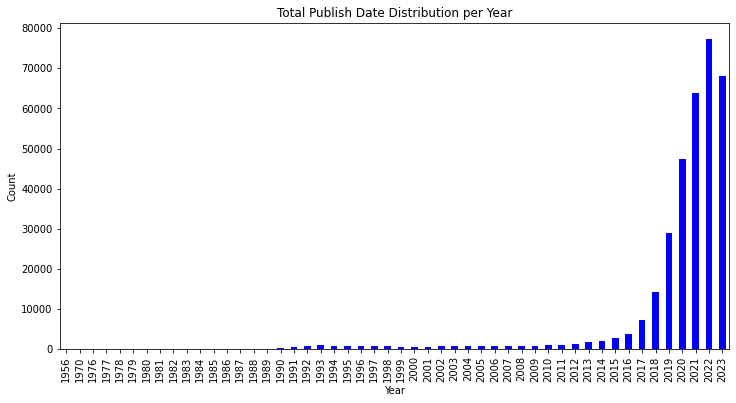

In [20]:
# Extract year
patents_total['year'] = patents_total['publication_date'].dt.year

# Plotting the bar chart for the total count per year
plt.figure(figsize=(12, 6))
patents_total['year'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.title('Total Publish Date Distribution per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()